# Diagnóstico del muestreo

In [1]:
#| code-fold: true

import arviz as az
import preliz as pz
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
#| code-fold: true

az.style.use('arviz-doc')

Los objetivos de este capítulo son:

* Obtener nociones básicas de métodos de Markov Chain Monte Carlo


## Revisitando el teorema de Bayes

El teorema de Bayes, tiene una formulación que a primera vista parece muy inocente. Tan solo cuatro términos relacionados por una multiplicación y una división.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Pareciera que no sirve de mucho y que es fácil de calcular. Sin embargo, ambas apreciaciones son incorrectas. El resto de los capítulos se centran en mostrar contra ejemplos a la primera aseveración, así que veamos por que a veces su cálculo puede ser difícil y se requieren métodos numéricos.

La razón está en el cálculo del likelihood marginal. El cual toma la forma de una integral.

$$
{p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
$$

Esta integral suele ser difícil de resolver. Veamos, esta expresión nos dice que debemos evaluar el likelihood para cada uno de los posibles valores del prior $\theta$. En la práctica esa tarea no siempre es sencilla o barata de realizar. Si $\theta$ representa un solo parámetro desconocido (como en el modelo beta-binomial) entonces solo hay que resolver una integral, pero si $\theta$ representa dos parámetros (como en el modelo Gaussiano) entonces la integral será doble. En definitiva la integral tendrá tantas dimensiones como parámetros el modelo. En general las integrales en grandes dimensiones no son simples de resolver.

Algo que puede ser poco intuitivo es que esto se contrapone con el cálculo de la distribución a posteriori. Para obtener una buena aproximación a la distribución a posteriori bastaría con concentrarse en las regiones donde tanto la contribución del prior como del likelihood son *relativamente grandes* (área gris en la siguiente figura), en general esto es lo que hacen la mayoría de los métodos numéricos. En cambio esta misma aproximación puede conducir a errores en el cálculo del likelihood marginal


<center><img src="img/grid.png" width=800></center>


Para algunos problemas es posible calcular la distribución a posteriori de forma analítica. Esto ya lo vimos para el modelo beta-binomial donde la posterior es:


$$
p(\theta \mid y) \propto \operatorname{Beta}(\alpha_{a priori} + y, \beta_{a priori} + N - y)
$$

Para esos casos suele ser posible también calcular el marginal likelihood de forma analítica.

Pero en general no tenemos expresiones analíticas y entonces debemos confiar en métodos numéricos.

## Calculando la distribución a posteriori

Hay muchas formas de calcular la distribución a posteriori

 * <font color = gray> Conjugación </font>
 * <font color = gray> Método de Laplace </font>
 * <font color = gray> Aproximación de Laplace Anidada Integrada (INLA) </font>
 * <font color = gray> Inferencia Variacional (VI) </font>
 * Markov Chain Monte Carlo (MCMC)
 * <font color = gray> Sequential Monte Carlo </font>
 * ...


Por ahora solo hablaremos de los métodos MCMC ya que, por el momento, son los métodos más generales. Pero para entender de forma más simple que es lo que hacen estos métodos conviene empezar desde otro método, conocido como método de la grilla.

### Método de la grilla

El método de grilla es un enfoque simple de fuerza bruta. La idea central es que incluso si no somos
capaces de calcular todo la distribución a posteriori, en general si somos capaces de evaluar el
a priori y el likelihood punto-a-punto.

Para un modelo con un solo parámetro el método de la grilla se puede resumir de la siguiente forma:

* Encuentre un intervalo razonable para el parámetro (el prior debe dar algunas pistas).

* Defina una grilla de puntos (generalmente equidistantes) en ese intervalo.

* Para cada punto de la grilla, evalúe el prior y el likelihood en ese punto y multiplique


La siguiente figura ilustra este método


<center><img src="img/grid.gif" width=800></center>


Para obtener una mejor aproximación se puede aumentar el número de puntos de la cuadrícula. Esta estrategia puede ser útil en unas pocas dimensiones (parámetros). Pero no escala muy bien. En la siguiente figura vemos que si necesitamos 4 puntos en 1D, para mantener ese mismo grado de precisión necesitaremos 16 puntos en 2D y 64 en 3D. La velocidad con la que crecen la cantidad de evaluaciones necesarias crece demasiado rápido, una grilla de 100 putos en 10 dimensiones requeriría de 1e+20 puntos! 

<center><img src="img/grid_dimensions.png" width=800></center>

Como si eso no fuera suficiente, la cosa es más complicada. En espacios de alta dimensión se dan una serie de fenómemos conocidos como **concentración de la medida** o en versión marketinera la **maldición de la dimensionalidad** 👻. Por ejemplo:

* En una hiper-esfera casi todo el volumen está en la superficie. Es decir, si uno pelara una hiper-naranja se quedaría con hambre!

* En un hiper-cubo la masa se concentra en las esquinas
 
* En una Gaussiana hiper-dimensional casi toda la masa está lejos de la moda

La idea de estimar la distribución a posteriori evaluando, punto a punto,  likelihood y prior es muy buena, pero la idea de construir una grilla predefinida solo funciona en muy bajas dimensiones.

Pero no todo está perdido, que tal si mantenemos la idea de la evaluación puntual, pero nos concentramos en las *regiones que importan*?

### Markov Chain Monte Carlo (MCMC)

Esta es una familia muy extensa de métodos utilizados para resolver muchos problemas, entre los que se encuentra el cálculo de la distribución a posteriori. Conceptualmente se puede pensar a estos métodos como generalizaciones del método de la grilla, ya que también se basan en la posibilidad de realizar evaluaciones punto a punto del prior y likelihood. La diferencia crucial es que en vez de utilizar una grilla predefinida el método realiza evaluaciones que progresivamente se concentran en regiones de alta probabilidad. No solo eso si no que eventualmente el método devolverá muestras de forma proporcional a la probabilidad a posteriori. Es decir si una región es 3 veces más probable que otra obtendremos 3 veces más muestras de esa región que de la otra.

A muy grandes rasgos, y dado un punto inicial arbitrario, los métodos MCMC, constan de dos pasos. 

1. Generar un nuevo punto a partir de perturbar uno preexistente.
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.

Esta es esencialmente la receta, la forma exacta en que hacemos cada uno de estos pasos define los distintos métodos dentro de la familia MCMC. Veamos uno de los más sencillos de entender y de implementar.

### Metropolis-Hastings

Metropolis-Hastings no es un algoritmo muy moderno o particularmente eficiente, pero Metropolis-Hastings es simple de entender y también proporciona una base para comprender métodos más sofisticados y poderosos. 

El algoritmo Metropolis-Hasting se define de la siguiente manera:

1. Inicialice el valor del parámetro $\boldsymbol{X}$ en $x_i$
2. Utilice una distribución de propuesta $q(x_{i + 1} \mid x_i)$ para generar un nuevo valor $x_{i + 1}$
3. Calcule la probabilidad de aceptar el nuevo valor como:

$$
p_a (x_{i + 1} \mid x_i) = \min \left(1, \frac{p(x_{i + 1}) \; q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
$$

4. Si $p_a > R$ donde $R \sim \mathcal{U}(0, 1)$, guarde el nuevo valor; de lo contrario, guarde el anterior.
5. Iterar de 2 a 4 hasta que se haya generado una muestra *suficientemente grande*


El algoritmo Metropolis es muy general y se puede usar en aplicaciones no Bayesianas, pero para la presente discusión, $p(x_i)$ es la densidad del posterior evaluada en el valor del parámetro $x_i$. Una forma de simplificar un poco el método es notar que si $q$ es una distribución simétrica, los términos $q(x_i \mid x_{i + 1})$ y $q(x_{i + 1} \mid x_i)$ se cancelarán (conceptualmente significa que es igualmente probable que vayamos de $x_{i+1}$ a $x_i$ o de $x_{i}$ a $x_{i+1}$), dejando solo un cociente entre el posterior evaluado en dos puntos. Este algoritmo siempre aceptará moverse de una región de baja probabilidad a una más alta y aceptará probabilísticamente moverse de una región de alta a una baja probabilidad.

¡Otra observación importante es que el algoritmo Metropolis-Hastings no es un método de optimización! No nos importa encontrar el valor del parámetro con la máxima probabilidad, queremos _explorar_ la distribución $p$. Es decir aún si el método encuentra un máximo aún puede moverse a regiones de probabilidades más bajas.

Para hacer las cosas más concretas, intentemos resolver el modelo Beta-Binomial. 

\begin{aligned}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\end{aligned}

Este modelo tiene solución analítica. Pero supongamos que no sabemos cómo calcularla, y por lo tanto, implementaremos el algoritmo Metropolis-Hastings usando Python. 

In [3]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = pz.Beta(α, β).pdf(θ)
        like  = pz.Bernoulli(θ).pdf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

También necesitamos datos, por lo que generaremos algunos datos falsos aleatorios para este propósito.

In [4]:
Y = pz.Bernoulli(0.7).rvs(20, random_state=123)

Y finalmente ejecutamos nuestra implementación del algoritmo Metropolis-Hastings:

In [5]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5 
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)  
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

/tmp/ipykernel_17064/2595604670.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace["θ"][iter] = θ


En la línea 9 del bloque de código anterior generamos una propuesta muestreando una distribución Normal con desviación estándar `can_sd`. En la línea 10 evaluamos el posterior en el nuevo valor generado `θ_can` y en la línea 11 calculamos la probabilidad de aceptación. En la línea 17 guardamos un valor de `θ` en el array `trace`.  Dependiendo del resultado de la comparación en la línea 13, el valor guardado será nuevo o repetiremos el anterior.

El primer panel de la siguiente figura muestra cada valor muestreado en cada paso, y el panel de la derecha el histograma de esos valores. El resultado parece razonable. Nada mal para unas pocas lineas de código!

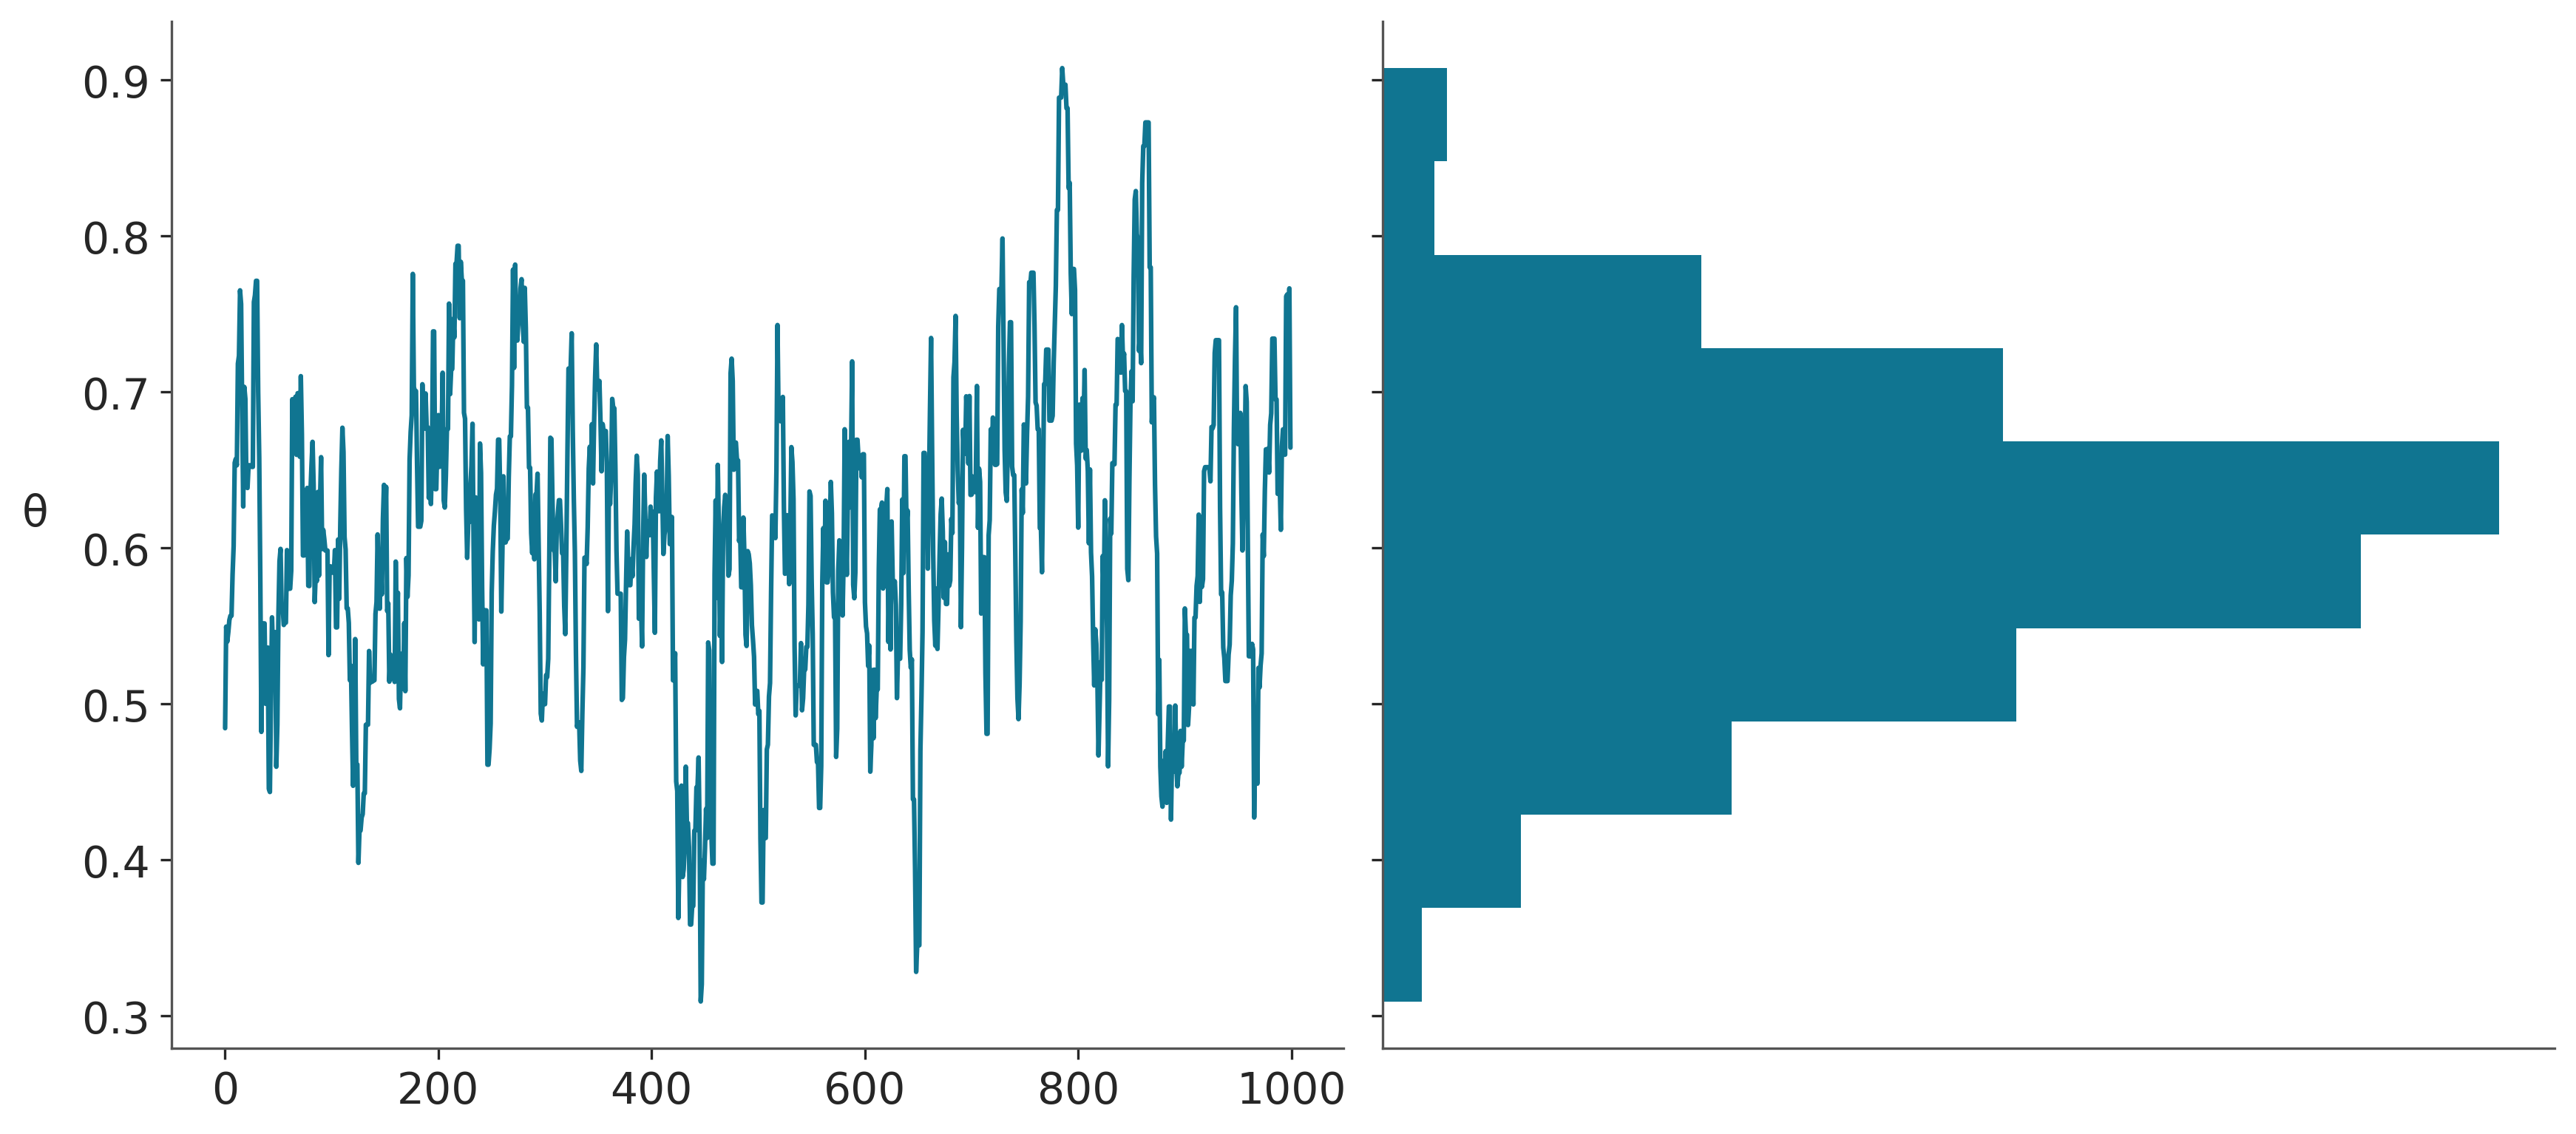

In [6]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'])
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

[Acá](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana) pueden ver una versión interactiva de un Metropolis-Hastings

### MH adaptativo

En teoría, y si tomáramos infinitas muestras, cualquier distribución de propuesta sería igualmente útil. Sin embargo, en la práctica no podemos tomar infinitas muestras y por lo tanto la eficiencia puede cambiar drásticamente de acuerdo a la distribución de propuesta que utilicemos. Además, la eficiencia de una distribución de propuesta dada dependerá de la geometría de la distribución a posteriori. Por ejemplo, si la distribución a posteriori es muy alargada en una dirección y muy angosta en otra, una distribución de propuesta que isotrópica será ineficiente.

Varios estudios teóricos muestran que bajos ciertas condiciones la tasa de aceptación óptima para MH es de 0.4 en una dimensión y $\approx 0.234$ en el límite de dimensión infinita. En la práctica "infinito" suele ser "< 10". Por lo que en la práctica los métodos de MH suelen tener una fase the ajuste (tuning) donde se modifica algún aspecto de la distribución de propuesta de forma tal de lograr tasas de aceptación entre 0.23 y 0.4. Existen muchos esquemas de ajuste uno común es usar como distribución de propuesta una gaussiana multivariada y ajustar la varianza de forma adaptativa. Muchas veces la matriz de covarianza usada es diagonal y se ajusta por separado cada componente.

En general las muestras generadas durante el ajuste no son válidas, esencialmente al cambiar lo hiper-parámetros del método, perdemos las garantías teóricas que aseguran que un MCMC sea valido. Es por ello que en la práctica se suele descartar las muestras generadas durante el ajuste. Vale aclarar que es posible diseñar esquemas de ajuste que no requieran descartar muestras, pero estos son más complejos y no son tan comunes.

Si un esquema MCMC no cuenta con una fase de ajuste, es probable que no sea muy eficiente. La fase de ajuste permite que el método se adapte a la geometría de la distribución a posteriori y por lo tanto nos permite resolver problemas más complejos.

* Aún el RWMH adaptativo puede tener problemas para ciertas problemas
    * Parámetros muy correlacionados
    * Alta dimensión (muchos parámetros)
    * Geometrías complejas


Existen otras formas de generar mejores propuestas

### Montecarlo Hamiltoniano (HMC)

Supongamos que queremos simular el movimiento de una partícula, sin fricción, sobre una superficie. Si queremos que nuestra simulación sea fidedigna necesitamos describirla usando leyes de la física. Una forma de describir el movimiento de la partícula es utilizando lo que se conoce como mecánica Hamiltoniana. Sin entrar en detalles diremos que un Hamiltonianio es una descripción de la energía total de un sistema físico. En el caso de nuestra partícula necesitamos 2 componentes. La energía cinética y la potencial. La energía cinética es la energía asociada al movimiento de la partícula y la potencial es la energía asociada a la posición de la partícula. La energía total es la suma de ambas.

$$
\underbrace{H(\overbrace{\mathbf{q}}^{\text{posición}}, \overbrace{\mathbf{p}}^{\text{momemtum}})}_{\text{Hamiltoniano}}  = \underbrace{K(\mathbf{p}, \mathbf{q})}_{\text{Energía cinética}} + \underbrace{V(\mathbf{q})}_{\text{Energía potencial}}
$$

Supongamos que nuestra superficie tiene una forma de U. Y nuestra partícula está en la parte más baja. Esa partícula tendrá energía potencial 0 y si está quieta energía cinética 0. Nuestra simulación será terriblemente aburrida, ya que la partícula permanecerá en esa posición para siempre. Para ponerle algo de diversión podemos empujar la partícula, es decir le impartimos momentum, la partícula se moverá hacia arriba perdiendo cada vez más energía cinética (cada vez se moverá más lento) y ganando potencial, hasta que llegue a un punto en que se detenga, en ese punto toda la energía cinética se habrá convertido en potencial y la partícula comenzara a caer y la energía potencial se convertirá en cinética. Como no hay fricción la energía total del sistema se mantiene constante. Y todo los cambios en la energía cinética son compensados por cambios en la energía potencial.

Desde un punto de vista matemático da igual si la superficie es una U, como una media tubería o una montaña rusa, un satélite en órbita o incluso una distribución a posteriori. En todos estos casos podemos describir el movimiento de la partícula usando un Hamiltoniano.

La siguiente figura muestra un ejemplo de un distribución a posteriori 2D y una trayectoria de una partícula

<center><img src="diapo/img/Hamiltonian_Monte_Carlo.gif" width=400></center>

En el caso de la distribución a posteriori la posición la posición de la particula son los valores de los parámetros. La energía potencial vendrá dada por por la densidad de probabilidad a posteriori, estrictamente por el menos logaritmo de esa densidad. Y el momentum es una variable auxiliar. Es decir una variable completamente inventada, pero útil por que nos permite calcular el hamiltoniano. 

$$
H(\mathbf{q}, \mathbf{p}) = \overbrace{-\log p(\mathbf{p} \mid \mathbf{q})}^{K(\mathbf{p}, \mathbf{q})} \overbrace{- \log p(\mathbf{q})}^{ + V(\mathbf{q})}
$$

Fijensé que en este punto no estamos haciendo ninguna analogía, estrictamente un Hamiltonian MonteCarlo es un método que simula el movimiento de una partícula en un espacio de parámetros.

Entonces, a grandes rasgos un HMC tiene dos pasos que se repiten hasta obtener la cantidad de muestras necesarias:

1. Generar un nuevo punto a partir del hamiltoniano
2. Aceptar o rechazar ese nuevo punto según el criterio de metropolis.

Para generar mejor intuición recomiendo jugar con ese [demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana)

Por qué es buena idea usar el Hamiltoniano? Por que estamos usando una descripción fidedigna del un sistema para explorarlo. OK, si eso es cierto pero no genera demasiada intuición. Veamos un par de enfoques alternativos. 

En un MH la propuesta es aleatoria, es como querer encontrar algo en una habitación desconocida a oscuras, hay que ir a tientas. Si la habitación es pequeña y simple (cuadrada, con pocos muebles, escaleras etc) hacerlo a ciegas no será tarea demasiado compleja. Sin embargo con el Hamiltoniano es como tener una linterna, ahora podemos ver, al menos localmente, que hay en la habitación, por lo que recorrerla será más eficiente. 

Vamos con otra explicación, para resolver un hamiltoniano necesitamos calcular derivadas, las derivadas nos dan información sobre la curvatura de una función, por ejemplo el cálculo de la primer derivada en un punto nos dice hacia donde (de)crece una función. Si siguiéramos la derivada hacia donde crece la función, eventualmente llegaríamos a un máximo (asumiendo que este existe). Esto se llama maximizar una función y de hecho muchos métodos de minimización de funciones como los encontrados en [SciPy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) utilizan derivadas. Al agregar el *momemtum* podemos hacer algo más interesante, no solo podemos encontrar máximos, también podemos escapar de ellos. Esto nos permite obtener puntos de toda la distribución a posteriori de forma eficiente. Esto es importante en estadística Bayesiana, ya que no solo queremos el máximo, si no una descripción de toda la distribución a posteriori.


<center><img src="diapo/img/hmc_landscape.gif" width=700></center>

Un HMC tiene varios hipeparámetros, por ejemplo para simular una trayectoria tenemos que hacerlo de a pasos discretos, mientras más pequeños los pasos más fidedigna la simulación, pero también más costosa. Otro hiperparámetro es la longitud de cada simulación si esta es muy corta demoraremos mucho tiempo en explorar la distribución a posteriori, pero si está es muy larga corremos el riesgo de volver al mismo lugar.

En la siguiente figura se muestran tres ejemplos. A la izquierda el paso es muy corto, por lo que la exploración no es eficiente, en el centro el paso es correcto pero simulamos durante tanto tiempo que terminamos regresando al punto de partida. Finalmente y a la derecha tanto el paso como el tiempo de simulación son adecuamos. La propuesta genera un punto alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación. De hecho en este ejemplo la probabilidad de aceptación es 1, ya que el valor de la pdf es el mismo para el punto de partida y para el punto final.

<center><img src="img/hmc_1D.gif" width=900></center>

Este es otro ejemplo, en cada caso se muestra una densidad de probabilidad que va de más probable (amarillo) a menos probable (violeta), las flechas naranjas indican la trayectoria calculada de a pasos. En en el primer caso vemos una trayectoria elíptica tan larga que vuelve al punto de partida. En el segundo ejemplo vemos que el paso no es adecuado, esto produce una simulación inestable que se manifiesta en **divergencias** de la trayectoria correcta.  En este último caso, y como en el ejemplo anterior, vemos que tanto el paso como el tiempo de simulación son adecuamos y la propuesta genera un punto alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación (1 en este caso).


<center><img src="diapo/img/HMC_trayectoria.png" width=900></center>

Las divergencias ocurren cuando hay cambios de "curvatura" demasiado bruscos. Es decir cuando la partícula pasa de zonas de baja densidad de probabilidad a zonas de alta densidad o viceversa. En estos casos el método de integración numérica que se utiliza para resolver el hamiltoniano no es suficientemente preciso. PyMC registra cuando las divergencias ocurren y como veremos más adelante, es posible utilizar las divergencias para diagnosticar problemas con el método de muestreo.

Al igual que en un MH adaptativo, en un HMC también necesitamos ajustar la matriz de covarianza, usualmente llamada Matriz de Masa (mass matrix). En HMC esta matriz es la que determina el momemtum.


Cuando los hiper-parámetros de un HMC son adecuados, el muestreo es muy eficiente. De hecho es mucho más eficiente que un MH. Los valores de los hiper-parámetros dependen esencialmente de la geometría de la distribución a posteriori, por lo que no existe un solo conjunto de hiper-parámetros mejor que los demás. Es por ello que en la práctica estos se calculan de forma adaptativa corriendo una cantidad de pasos de HMC los cuales se utilizan para ajustar eso hiper-parámetros automáticamente y luego se descartan. 

NUTS (No U-Turn sampler), el sampler por defecto en PyMC es un HMC dinámico y adaptativo. El nombre proviene de una rutina del método que evita que las trayectorias den vueltas en U. Este método detecta en cada paso de si estamos retornando el punto de partida, de ser así detiene el paso, evalúa si aceptar o no y comienza un nuevo paso. Al evitar trayectoria que vuelven al punto de partida, NUTS es capaz de explorar la distribución a posteriori de forma más eficiente. 

## Otros métodos MCMC

Existen una enorme cantidad de métodos MCMC, el más popular en estadística Bayesiana es NUTS o estrictamente variantes más modernas como las implementadas en PyMC, STAN, etc. De hecho muchas de estas variantes se van incorporando a los paquetes en la medida que se publican nuevos métodos. Tradicionalmente los métodos MCMC se ejecutan unas pocas cadenas en paralelo (4 o más) y cada cadena es larga cientos a miles de pasos. En los últimos años han surgido mucho interés en métodos que aprovechen GPUs o TPUs. Estos métodos son capaces de ejecutar muchas cadenas en paralelo y cada cadena es mucho más corta.